# NASA NeoWs API: Potentially Hazardous Asteroids
### Find out how many potentially hazardous asteroids were present each month in a given date range.
---
#### Objective of NASA API Portal:

   To make NASA data eminently accessible to application developers.

#### NeoWs API:

   Provides near earth Asteroid information.<br>
   Useful for anyone curious about astronomical happenings.

In [1]:
import pandas as pd
import requests
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def are_dates_ok(start, end):
    '''This function checks that start <= end. If so, returns True. If not, returns False.'''
    if end <= start:
        print('\n\nERROR: End date must be greater than start date!\n')
        return False
    else:
        return True
    
def get_date_range():
    '''Solicit user for start date and end date. Returns start_date and end_date.'''
    
    # False if start_date > end_date, true otherwise. False by default.
    dates_ok = False
    
    while not dates_ok:
        print ('\nStart date must be less than end date.\n')
    
        # get start_date
        start_year = int(input('Enter year of start date (YYYY): '))
        start_month = int(input('Enter month of start date (MM): '))
        start_day = int(input('Enter day of start date (DD): '))
        
        # get end_date
        end_year = int(input('Enter year of end date (YYYY): '))
        end_month = int(input('Enter month of end date (MM): '))
        end_day = int(input('Enter day of end date (DD): '))
        
        # convert to datetime objects
        start_date = datetime.date(start_year, start_month, start_day)
        end_date = datetime.date(end_year, end_month, end_day)
        
        # check to see if start_date <= end_date
        dates_ok = are_dates_ok(start_date, end_date)
        
    return (start_date, end_date)

In [3]:
# filter the contents of the 'near_earth_objects' key into a dictionary
def get_data(near_earth_objects):
    '''Creates dictionary for asteroid properties and fills dictionary with data from JSON response.'''
    
    # make an empty dictionary with keys of useful features picked from the contents of 'near_earth_objects' key
    asteroid_dict = {'name': [], 'close_approach_date': [], 'miss_distance_miles': [],
                     'relative_velocity_mph': [], 'est_diameter_max_feet': [], 'is_potentially_hazardous_asteroid': []}

    # iterate through each day of the span of days selected
    for date in near_earth_objects:

        # iterate through the list of entries for the day
        for entry in near_earth_objects[date]:
        
            # iterate through each key of the dictionary making up each entry
            for key in entry:
            
                # seek out only relevant portions of data
                if (key in ['name','close_approach_data','relative_velocity','estimated_diameter','is_potentially_hazardous_asteroid']):
                
                    # maneuver through the nested lists and dictionaries
                    if (key == 'close_approach_data'):
                        asteroid_dict['close_approach_date'].append(entry[key][0]['close_approach_date'])
                        asteroid_dict['relative_velocity_mph'].append(entry[key][0]['relative_velocity']['miles_per_hour'])
                        asteroid_dict['miss_distance_miles'].append(entry[key][0]['miss_distance']['miles'])
                    elif (key == 'estimated_diameter'):
                        asteroid_dict['est_diameter_max_feet'].append(entry[key]['feet']['estimated_diameter_max'])
                    else:
                        asteroid_dict[key].append(entry[key])
                else:
                    pass
    
    return asteroid_dict

In [4]:
def asteroid_func(start, end):
    '''Takes in start date and end date. These dates are ensured to be properly formatted with a leading zero and
    then a url is made using these dates. The API request is sent using the url and the response is formatted in JSON
    and then passed to a function that will create a dictionary using the response. This dictionary is returned.
    Function returns the complete dictionary.'''
    
    # make start_date and end_date parameters
    start_date_str = str(start.year) + '-' + str(start.month).zfill(2) + '-' + str(start.day).zfill(2)
    end_date_str = str(end.year) + '-' + str(end.month).zfill(2) + '-' + str(end.day).zfill(2)

    # combine elements to make complete URL
    path = 'https://api.nasa.gov/neo/rest/v1/feed?'
    search_time_span = 'start_date=' + start_date_str + '&end_date=' + end_date_str
    api_key = '&api_key=hzN9EE6vqZlamYgP1upHISVIxvXEQo5WKxa174ez'
    url = path + search_time_span + api_key
    
    # get data
    response = requests.get(url)
    
    # parse JSON reponse and grab the contents of 'near_earth_objects' key
    near_earth_object = response.json()['near_earth_objects']
    
    # make a filtered dictionary out of the contents of 'near_earth_objects' key
    asteroid_dict = get_data(near_earth_object)
    
    return asteroid_dict

In [5]:
def main():
    # get start_date and end_date
    start, end = get_date_range()

    # variable to keep record of start_date
    START_PERM = start

    # get difference between dates
    date_difference = end - start

    # if the difference in days <= 7
    if date_difference.days <= 7:

        returnDict = asteroid_func(start, end)
        asteroid_dataFrame = pd.DataFrame(returnDict)

    # the difference in days > 7
    else:
        # create empty dataFrame. This will be our primary dataFrame
        asteroid_dataFrame = pd.DataFrame()

        # create datetime object 7 days greater than start_date
        tempDate = start + datetime.timedelta(7)

        while start != end:
            returnDict = asteroid_func(start, tempDate)
            tempDataFrame = pd.DataFrame(returnDict)

            # add tempDataFrame to primary dataFrame
            asteroid_dataFrame = asteroid_dataFrame.append(tempDataFrame)

            start = tempDate
            date_difference = end - tempDate

            # if the difference in days <= 7, then we are 7 days or less away from end_date
            if date_difference.days <= 7:
                tempDate = end
            # we are not within 7 days of end_date and need to keep querying in 7 day blocks
            else:
                tempDate = tempDate + datetime.timedelta(7)

    # change data type of columns
    asteroid_dataFrame['est_diameter_max_feet'] = asteroid_dataFrame.est_diameter_max_feet.astype(float)
    asteroid_dataFrame['relative_velocity_mph'] = asteroid_dataFrame.relative_velocity_mph.astype(float)
    asteroid_dataFrame['miss_distance_miles'] = asteroid_dataFrame.miss_distance_miles.astype(float)

    # given a date of the format YYYY-MM-DD, return the month converted to an int
    asteroid_dataFrame['close_approach_month'] = asteroid_dataFrame.close_approach_date.apply(lambda x: int(x.split('-')[1]))
    # given a date of the format YYYY-MM-DD, return (YYYY, MM)
    asteroid_dataFrame['close_approach_month_year'] = asteroid_dataFrame.close_approach_date.apply(lambda x: (x.split('-')[0], x.split('-')[1]))
    # given a name, return only the value inside the parentheses
    asteroid_dataFrame['asteroid_name'] = asteroid_dataFrame.name.apply(lambda x: x[(x.index('(') + 1): x.index(')')])

    # make name column the index column for ease of row identification according to asteroid name
    asteroid_dataFrame.set_index('asteroid_name', inplace=True)

    # filter for potentially hazardous asteroids
    filtered_dataFrame = asteroid_dataFrame[asteroid_dataFrame['is_potentially_hazardous_asteroid']==True]

    # plot the data
    size_by_month = filtered_dataFrame.groupby('close_approach_month_year').size().plot(kind='bar',figsize= (10,10))

    monthDict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}
    xTickLabels = [monthDict[int(x.get_text().split(' ')[1].strip(')'))] + ' ' + x.get_text().split(' ')[0].strip('(').strip(',') for x in size_by_month.get_xticklabels()]
    
    size_by_month.grid(True, linestyle='--')
    size_by_month.set_xticklabels(xTickLabels)
    size_by_month.set_xlabel('\nMonth')
    size_by_month.set_ylabel('Frequency')
    size_by_month.set_title('Number of Potentially Hazardous Asteroids\nPer Month From {}-{}-{} to {}-{}-{}'.format(START_PERM.month,START_PERM.day,START_PERM.year,end.month,end.day,end.year))


Start date must be less than end date.

Enter year of start date (YYYY): 2017
Enter month of start date (MM): 01
Enter day of start date (DD): 01
Enter year of end date (YYYY): 2018
Enter month of end date (MM): 01
Enter day of end date (DD): 01


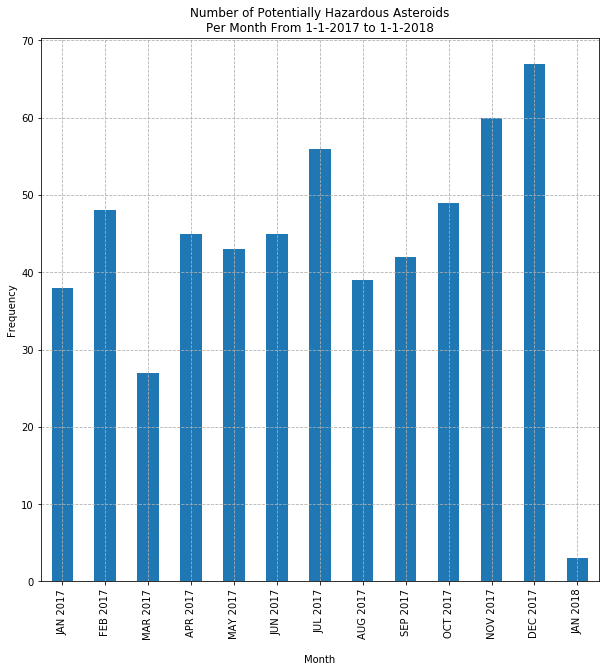

In [6]:
if __name__ == '__main__':
    main()